In [1]:
# pip install git+https://github.com/xunzheng/notears.git

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 전처리
df = pd.read_csv("training_data_asset_liabilities_shuffled.csv")
# X = df.values
# label 제거 필요
X = df.drop(columns=["Unnamed: 0", "label"]).values
X = StandardScaler().fit_transform(X)

# NOTEARS 실행
W = notears_linear(X, lambda1=0.1, loss_type='l2')  # lambda1으로 sparsity 조절

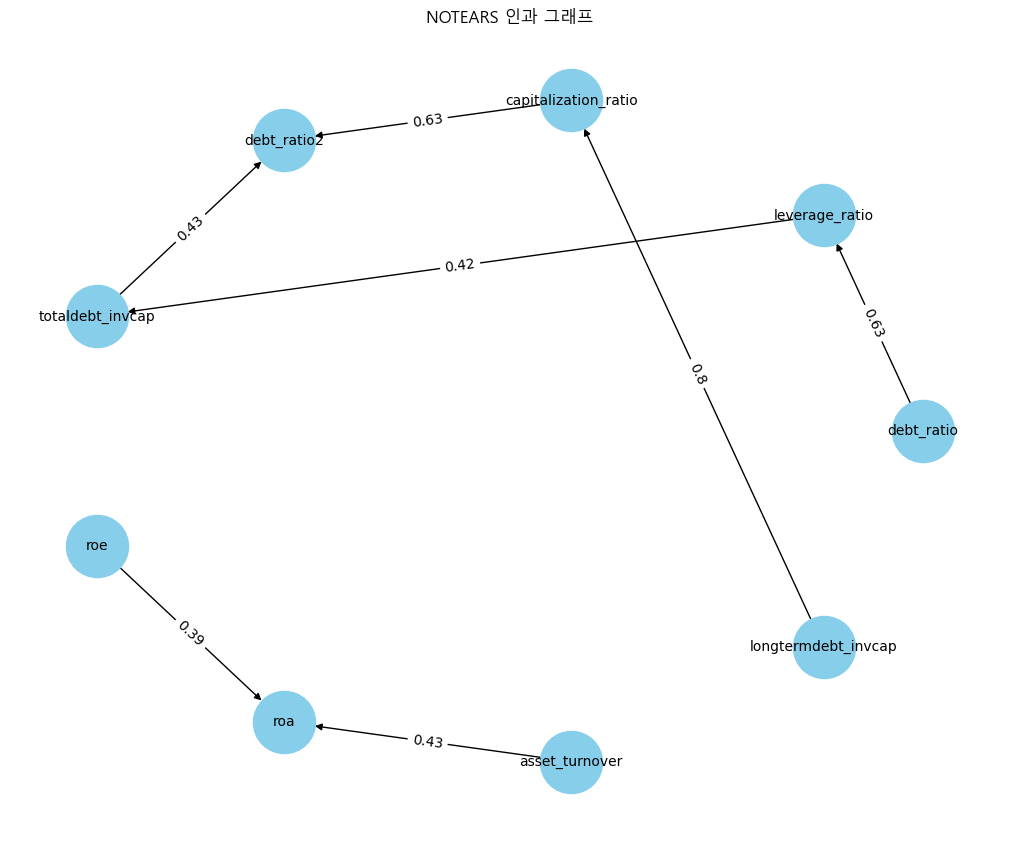

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 인과 그래프 시각화
cols = df.columns[1:-1]  # label 제외한 열 이름
G = nx.DiGraph()

for i in range(len(cols)):
    for j in range(len(cols)):
        if abs(W[i, j]) > 0.01:  # threshold 적용(0 제외)
            G.add_edge(cols[j], cols[i], weight=round(W[i, j], 2))

plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("NOTEARS 인과 그래프")
plt.show()


In [4]:
# ============================================
# NOTEARS → eps 필터(Top-K 없음) → mul/mulw → O/F/OF (FFMLP only)
# O는 1회만 학습, m/mw 구간의 O-*는 재학습 없음(재활용)
# 10-fold CV / 결과: 행[original, m, mw] × 열[O,F,OF × f1,AUPRC,AUROC,Brier,ECE]
# ============================================

import warnings
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# NOTEARS
from notears.linear import notears_linear

# ---------------- 설정 ----------------
RANDOM_STATE   = 42
N_SPLITS       = 10
PRINT_PROGRESS = True

TOP_K_EDGES: Optional[int] = None  # Top-K 제한 제거
W_EPS       = 1e-12                # 0/극소 가중치 임계값 낮춤

LABEL_COL    = "label"
ID_DROP_COLS = ["Unnamed: 0", "Unnamed: 1"]

# =============== 유틸 ===============
def expected_calibration_error(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    if len(np.unique(y_true)) < 2:
        return np.nan
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece, total = 0.0, len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if mask.sum() == 0:
            continue
        acc  = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def best_threshold_by_f1(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    ts = np.linspace(0.05, 0.95, 19)
    scores = [(t, f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)) for t in ts]
    t_best, _ = max(scores, key=lambda x: x[1])
    return float(t_best)

def remove_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.shape[1] == 0:
        return df
    var = df.var(axis=0, ddof=0)
    keep = var[~np.isclose(var.values, 0.0)].index
    return df[keep]

# =============== NOTEARS ===============
def run_notears(X: np.ndarray, lambda1: float = 0.01, loss_type: str = 'l2') -> np.ndarray:
    return notears_linear(X, lambda1=lambda1, loss_type=loss_type)

def pick_top_k_edges(W: np.ndarray, cols: List[str], top_k: Optional[int], eps: float) -> List[Tuple[int,int,float]]:
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = float(W[i, j])
            if abs(w) > eps:
                flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    if len(flat) == 0:
        return []
    return flat if top_k is None else flat[:min(top_k, len(flat))]

def build_feature_df(X_base: pd.DataFrame, cols: List[str], W: np.ndarray,
                     feature_type: str = "mul", top_k: Optional[int] = None, eps: float = 1e-12) -> pd.DataFrame:
    edges = pick_top_k_edges(W, cols, top_k=top_k, eps=eps)
    if len(edges) == 0:
        return pd.DataFrame(index=X_base.index)

    feats = {}
    for i, j, w_ij in edges:
        A, B = cols[j], cols[i]
        if feature_type == "mul":
            feats[f"{A}_mul_{B}"] = X_base[A] * X_base[B]
        elif feature_type == "mulw":
            feats[f"{A}_mulw_{B}"] = float(w_ij) * (X_base[A] * X_base[B])
    X_feat = pd.DataFrame(feats, index=X_base.index)
    return remove_constant_columns(X_feat)

# =============== CV (FFMLP only) ===============
def make_model_ffmlp():
    # 스케일 + MLP(3층) 파이프라인
    return Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation="relu",
            solver="adam",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=300,
            random_state=RANDOM_STATE
        ))
    ])

def run_cv_ffmlp(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    if X is None or X.shape[1] == 0:
        return {m: np.nan for m in ["f1","AUPRC","AUROC","Brier","ECE"]}

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X.values, y.values.astype(int)), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # 내부 검증 분리(임계값 선택)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        clf = make_model_ffmlp()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X_tr_sub, y_tr_sub)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        t = best_threshold_by_f1(y_val, y_val_proba)

        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= t).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        aurocs.append(roc_auc_score(y_te, y_proba))
        auprcs.append(average_precision_score(y_te, y_proba))
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": np.mean(f1s),
        "AUPRC": np.mean(auprcs),
        "AUROC": np.mean(aurocs),
        "Brier": np.mean(briers),
        "ECE": np.mean(eces),
    }

# =============== 메인 ===============
df = pd.read_csv("training_data_asset_liabilities_shuffled.csv")

feature_cols = [c for c in df.columns if c not in ID_DROP_COLS + [LABEL_COL]]
X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int)

# 분산 0 제거
var0_cols = [c for c in feature_cols if np.isclose(X_base[c].var(ddof=0), 0.0)]
cols_used = [c for c in feature_cols if c not in var0_cols]
X_used = X_base[cols_used].copy()

# NOTEARS (표준화는 NOTEARS 계산에만 사용)
scaler_nt = StandardScaler()
X_for_notears = scaler_nt.fit_transform(X_used.values.astype(float))
W_used = run_notears(X_for_notears, lambda1=0.01, loss_type='l2')

# 파생 피처 생성
Xf_m  = build_feature_df(X_base, cols_used, W_used, feature_type="mul",  top_k=TOP_K_EDGES, eps=W_EPS)
Xf_mw = build_feature_df(X_base, cols_used, W_used, feature_type="mulw", top_k=TOP_K_EDGES, eps=W_EPS)

# 디버그 출력
edge_count = np.sum(np.abs(W_used) > W_EPS) - np.sum(np.abs(np.diag(W_used)) > W_EPS)
print(f"[DEBUG] edges(|w|>{W_EPS}): {edge_count}, Xf_m: {Xf_m.shape[1]}, Xf_mw: {Xf_mw.shape[1]}")

# ---- O 한 번만 학습 ----
res_O = run_cv_ffmlp(X_used, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="O")

# ---- m / mw는 F, OF만 계산 (O 재활용) ----
def eval_feat_sets_ffmlp(X_base_df, X_feat_df, tag_prefix="", res_O_cached=None):
    if X_feat_df is None or X_feat_df.shape[1] == 0:
        res_F  = {k: np.nan for k in ["f1","AUPRC","AUROC","Brier","ECE"]}
        res_OF = dict(res_O_cached) if res_O_cached is not None else {k: np.nan for k in ["f1","AUPRC","AUROC","Brier","ECE"]}
    else:
        res_F  = run_cv_ffmlp(X_feat_df, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"F-{tag_prefix}")
        res_OF = run_cv_ffmlp(pd.concat([X_base_df, X_feat_df], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    return res_F, res_OF

res_F_m,  res_OF_m  = eval_feat_sets_ffmlp(X_used, Xf_m,  tag_prefix="m",  res_O_cached=res_O)
res_F_mw, res_OF_mw = eval_feat_sets_ffmlp(X_used, Xf_mw, tag_prefix="mw", res_O_cached=res_O)

# 결과표 구성
col_top     = ["O", "F", "OF"]
col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows  = ["original","m","mw"]

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)

for met in col_metrics:
    report.loc["original", ("O", met)]  = res_O[met]
    report.loc["m", ("F", met)]         = res_F_m[met]
    report.loc["m", ("OF", met)]        = res_OF_m[met]
    report.loc["mw", ("F", met)]        = res_F_mw[met]
    report.loc["mw", ("OF", met)]       = res_OF_mw[met]

report = report.astype(float).round(4)
report

[DEBUG] edges(|w|>1e-12): 17, Xf_m: 17, Xf_mw: 17
[O] fold 1/10 ...
[O] fold 2/10 ...
[O] fold 3/10 ...
[O] fold 4/10 ...
[O] fold 5/10 ...
[O] fold 6/10 ...
[O] fold 7/10 ...
[O] fold 8/10 ...
[O] fold 9/10 ...
[O] fold 10/10 ...
[F-m] fold 1/10 ...
[F-m] fold 2/10 ...
[F-m] fold 3/10 ...
[F-m] fold 4/10 ...
[F-m] fold 5/10 ...
[F-m] fold 6/10 ...
[F-m] fold 7/10 ...
[F-m] fold 8/10 ...
[F-m] fold 9/10 ...
[F-m] fold 10/10 ...
[OF-m] fold 1/10 ...
[OF-m] fold 2/10 ...
[OF-m] fold 3/10 ...
[OF-m] fold 4/10 ...
[OF-m] fold 5/10 ...
[OF-m] fold 6/10 ...
[OF-m] fold 7/10 ...
[OF-m] fold 8/10 ...
[OF-m] fold 9/10 ...
[OF-m] fold 10/10 ...
[F-mw] fold 1/10 ...
[F-mw] fold 2/10 ...
[F-mw] fold 3/10 ...
[F-mw] fold 4/10 ...
[F-mw] fold 5/10 ...
[F-mw] fold 6/10 ...
[F-mw] fold 7/10 ...
[F-mw] fold 8/10 ...
[F-mw] fold 9/10 ...
[F-mw] fold 10/10 ...
[OF-mw] fold 1/10 ...
[OF-mw] fold 2/10 ...
[OF-mw] fold 3/10 ...
[OF-mw] fold 4/10 ...
[OF-mw] fold 5/10 ...
[OF-mw] fold 6/10 ...
[OF-mw] fold 7

O                                       F                  \
              f1   AUPRC   AUROC   Brier     ECE      f1   AUPRC   AUROC   
original  0.4251  0.3762  0.8725  0.0203  0.0193     NaN     NaN     NaN   
m            NaN     NaN     NaN     NaN     NaN  0.4312  0.3710  0.8788   
mw           NaN     NaN     NaN     NaN     NaN  0.4496  0.3782  0.8846   

                              OF                                  
           Brier     ECE      f1   AUPRC   AUROC   Brier     ECE  
original     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
m         0.0177  0.0109  0.4308  0.3901  0.8809  0.0184  0.0169  
mw        0.0176  0.0113  0.4176  0.3655  0.8702  0.0189  0.0165

In [5]:
# report: MultiIndex 컬럼의 결과 DataFrame이 이미 존재한다고 가정
# format 옵션: "multi" | "flat" | "long"
save_format = "multi"  # 원하는 포맷으로 변경

if save_format == "multi":
    out_path = "report_notears_ffmlp.csv"
    report.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "flat":
    out_path = "report_notears_ffmlp.csv"
    flat_cols = [f"{top}_{met}" for top, met in report.columns.to_list()]
    report_flat = report.copy()
    report_flat.columns = flat_cols
    report_flat.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "long":
    out_path = "report_notears_ffmlp.csv"
    report_long = (
        report
        .rename_axis(index="row", columns=["set", "metric"])
        .stack(["set", "metric"])
        .to_frame("value")
        .reset_index()[["row", "set", "metric", "value"]]
    )
    report_long.to_csv(out_path, index=False, encoding="utf-8-sig")
else:
    raise ValueError("save_format must be one of: 'multi', 'flat', 'long'")

print(f"Saved: {out_path} (format={save_format})")


Saved: report_notears_ffmlp.csv (format=multi)


In [6]:
# === Confusion Matrix (NOTEARS + FFMLP; O/F/OF, m+mw 제외) ===
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np, pandas as pd, re
from pathlib import Path

# 파일명 구성
DAG_ALGO   = "notears"
MODEL_NAME = "ffmlp"

def _snake(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("+"," ").replace("/"," ").replace("-"," ")
    s = re.sub(r"[^a-z0-9]+","_", s)
    return re.sub(r"_+", "_", s).strip("_")

SAVE_DIR  = Path("./confusion_matrix")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PATH = SAVE_DIR / f"{_snake(DAG_ALGO)}_{_snake(MODEL_NAME)}_cm.csv"

# OOF 예측 수집(각 fold에서 내부 val로 F1 최적 임계값 선택 → test fold 예측)
def _oof_cm_ffmlp(X: pd.DataFrame, y: pd.Series, n_splits: int, seed: int, tag: str):
    y_np = y.values.astype(int)

    # 피처가 없으면 전부 0 예측(방어)
    if (X is None) or (X.shape[1] == 0):
        y_pred_all = np.zeros_like(y_np)
        cm = confusion_matrix(y_np, y_pred_all, labels=[0, 1])
        return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

    X_np = X.values.astype(float)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    y_true_all, y_pred_all = [], []

    for tr_idx, te_idx in skf.split(X_np, y_np):
        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증 분리(임계값 선택)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=seed, stratify=y_tr
        )

        clf = make_model_ffmlp() if "make_model_ffmlp" in globals() else Pipeline(steps=[
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("mlp", MLPClassifier(hidden_layer_sizes=(128,64,32), activation="relu",
                                  solver="adam", alpha=1e-4, learning_rate_init=1e-3,
                                  max_iter=300, random_state=seed))
        ])
        clf.fit(X_tr_sub, y_tr_sub)

        # 검증으로 최적 임계값(F1)
        if "best_threshold_by_f1" in globals():
            val_proba = clf.predict_proba(X_val)[:, 1]
            thr = best_threshold_by_f1(y_val, val_proba)
        else:
            thr = 0.5

        te_proba = clf.predict_proba(X_te)[:, 1]
        te_pred  = (te_proba >= thr).astype(int)

        y_true_all.append(y_te)
        y_pred_all.append(te_pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
    return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

# 세트별 CM 수집 (O는 X_used, F/OF는 m, mw 파생특징)
cm_O     = _oof_cm_ffmlp(X_used,                           y, N_SPLITS, RANDOM_STATE, "O")
cm_F_m   = _oof_cm_ffmlp(Xf_m,                             y, N_SPLITS, RANDOM_STATE, "F(m)")
cm_OF_m  = _oof_cm_ffmlp(pd.concat([X_used, Xf_m],  axis=1), y, N_SPLITS, RANDOM_STATE, "OF(m)")
cm_F_mw  = _oof_cm_ffmlp(Xf_mw,                            y, N_SPLITS, RANDOM_STATE, "F(mw)")
cm_OF_mw = _oof_cm_ffmlp(pd.concat([X_used, Xf_mw], axis=1), y, N_SPLITS, RANDOM_STATE, "OF(mw)")

# 표 구성 (m+mw 제외)
rows = [
    ("original","O",  cm_O),
    ("m","F",        cm_F_m),   ("m","OF",        cm_OF_m),
    ("mw","F",       cm_F_mw),  ("mw","OF",       cm_OF_mw),
]
cm_table = pd.DataFrame(
    [(r, s, d["TN"], d["FP"], d["FN"], d["TP"]) for r, s, d in rows],
    columns=["row","set","TN","FP","FN","TP"]
).set_index(["row","set"])

cm_table.to_csv(SAVE_PATH, encoding="utf-8-sig")
print(f"[saved] {SAVE_PATH.resolve()}")


[saved] D:\University\3-2\PADALab\bank_failure_prediction_2\practice\Bank_Failure_Prediction_2\Intervention\confusion_matrix\notears_ffmlp_cm.csv
